In [1]:
import warnings
warnings.filterwarnings("ignore")
import modulesForCalibration as mfc
import Forward as getMod
import matplotlib.pyplot as plt

#import readPlotOptionSurface_granular_k2_5 as marketSurface
import readPlotPutSurfaceedited as marketSurface
import numpy as np
import pandas as pd

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib import cm
import cmath
import math
from scipy.optimize import fmin


import plotly.plotly as py
import plotly.graph_objs as go

<Figure size 800x600 with 1 Axes>

# This report reflects the work of Lisa He, Alban Zapke, and Naijia Yao, for the project of volatility surface in Computational Methods in Finance with Prof. Hirsa.

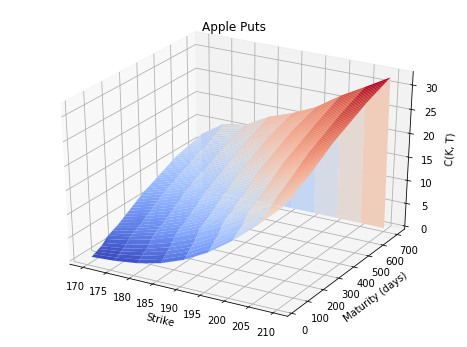

In [2]:
maturities, strikes, marketPrices = marketSurface.readNPlot()

In [3]:
maturities_years = maturities/365

In [4]:
startParams = [5,4,-3,2]

In [5]:
modelPrices = getMod.getModelPrice(startParams)

In [6]:
iArray = []                             # The alphas (0,1) which are plotted agains RMSE -> calling it i instead here
rmseArray = []
rmseMin = 1e10 

In [7]:
lenT = 98
lenK = 9
params1 = [5,4,-3,2]
params2 = [-3,.5, 6, -1.5]

In [8]:
def myeValue(marketPrices,modelPrices):
    count = 0
    mae = 0
    for i in range(lenT):
        for j in range(lenK):
            if (not math.isnan(modelPrices[i,j]) and modelPrices[i,j]>0 and -10000000<marketPrices[i,j]-modelPrices[i,j]<1000000):
                count  = count+1
                tmp = marketPrices[i,j]-modelPrices[i,j]
                #print (tmp)
                mae += tmp**2
    #print (count)
    #print (mae)
    if (count ==0):
        rmse =0
    else:
        rmse = math.sqrt(mae/count)
    return rmse

In [9]:
iArray = []
rmseArray=[]
for i in mfc.myRange(0.0, 1.0, 0.1):
    
    params = i*np.array(params1) + (1.0-i)*np.array(params2)
    iArray.append(i)
     
    rmse = myeValue(marketPrices, getMod.getModelPrice(params))
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

In [10]:
print(rmseArray)

[11.619051181783108, 15.585245785509565, 15.394808679010154, 16.67202039387424, 16.42658215690431, 16.43319104184907, 16.81814269815138, 16.34005594595371, 16.78806538524842, 18.931740964070077, 16.174309961849662]


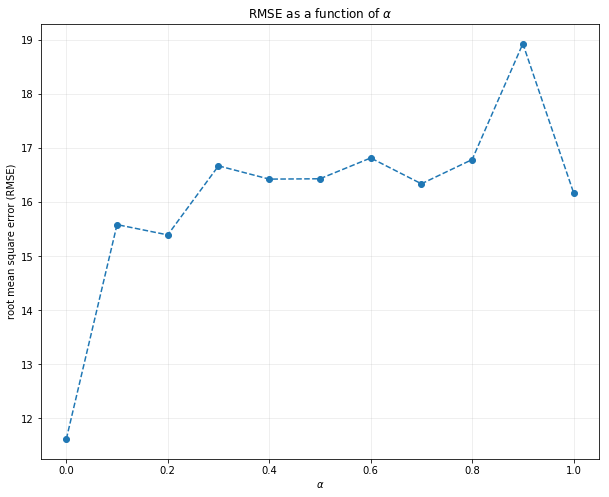

11.619051181783108
[-3.   0.5  6.  -1.5]


In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(iArray, rmseArray, 'o--')
plt.grid(alpha=0.25)
plt.xlabel('$\\alpha$')
plt.ylabel('root mean square error (RMSE)')
plt.title('RMSE as a function of $\\alpha$')
plt.show()

print(rmseMin)
print(optimParams)

In [12]:
## 2. Optimization of Parameter Set

In [13]:
def objFunc(v, x0, x1, x2):
    # Paraboloid centered on (x, y), with scale factors (10, 20) and minimum 30
    return 10.0*(v[0]-x0)**2 + 20.0*(v[1]-x1)**2 + 30.0*(v[2]-x2)**2 + 40.0

In [14]:
lenT = len(maturities)
lenK = len(strikes)

In [ ]:
#### A) Brute Force Algorithm 

In [15]:
# maturities, strikes, marketPrices = marketSurface.readNPlot()

#==========================================
# Grid Search around the starting point
#------------------------------------------
# [-3.   0.5  6.  -1.5]
ind_iter = 1
rmseMin = 1.0e6

for kappa in mfc.myRange(-4,-2,0.5):
    for theta in mfc.myRange(0,1,0.5):
        for sig in mfc.myRange(5,7,0.5):
            for rho in mfc.myRange(-2.5,-0.5,0.5):
                
                params = []
                params.append(kappa)
                params.append(theta)
                params.append(sig)
                params.append(rho)
                
                    
                #print('i = ' + str(ind_iter))
                ind_iter += 1
                #print(params)
                rmse = myeValue(marketPrices, getMod.getModelPrice(params))
                    
                if (rmse < rmseMin):
                    rmseMin = rmse
                    params2 = params
                    #print('\nnew min found')
                    #print(rmseMin)
                    #print(params2)
                    #print('')

print('\nSolution of grid search:')                        
print(params2)
print('Optimal rmse = ' + str(rmseMin))


Solution of grid search:
[-4, 0, 5, -2.0]
Optimal rmse = 0


In [16]:
params_BF = [-4, 0, 5, -2.0]

#### B) Nelder Mead Algorithm  (Gradient-free) from exampleCalibration_NelderMead.py

In [17]:
def myOpteValue(params):
    modelPrices = getMod.getModelPrice(params)
    count = 0
    mae = 0
    for i in range(lenT):
        for j in range(lenK):
            if (not math.isnan(modelPrices[i,j]) and modelPrices[i,j]>0 and -10000000<marketPrices[i,j]-modelPrices[i,j]<1000000):
                count  = count+1
                tmp = marketPrices[i,j]-modelPrices[i,j]
                #print (tmp)
                mae += tmp**2
    #print (count)
    #print (mae)
    if (count ==0):
        rmse =0
    else:
        rmse = math.sqrt(mae/count)
    return rmse

In [18]:
#==========================================
# Nelder-Mead Simplex Algorithm -- fmin
#==========================================
# [-3.   0.5  6.  -1.5]

params = [-3. ,  0.5 , 6.  ,-1.5]

def callbackF(xi):
    global num_iter
    global arg
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1


num_iter = 1
#xopt, fopt, iters, funcalls, warnflag, allvecs = fmin(
t = fmin(
        myOpteValue, 
        params,
        xtol=1e-4,
        ftol=1e-4,
        maxiter=200,
        maxfun=400,
        
        disp=True,
        retall=False,
        full_output=True)

print('optimal params = ')
print(t[0])
print('f = ' + str(t[1]))

optimal params = 
[-2.99997692  0.50017073  6.29672362 -1.5       ]
f = 10.539863188832761


In [19]:
params_NM = [-2.99997692 , 0.50017073,  6.29672362 ,-1.5       ]

In [ ]:
#### C) BFGS Algorithm (Gradient-based) from exampleCalibration_BFGS.py

In [20]:
from scipy.optimize import fmin_bfgs

params = [-3. ,  0.5 , 6.  ,-1.5]

def callbackF(xi):
    global num_iter
    global arg
    print(' ')
    print('i = ' + str(num_iter))
    print('x_i = ' + str(xi))
    print('f_i = ' + str(mfc.eValue(xi, *arg)))
    num_iter += 1


num_iter = 1
[xopt, fopt, gopt, Bopt, func_calls, grad_calls, warnflg] = fmin_bfgs(
        myOpteValue,
        params,
         
        fprime=None,
        
        maxiter=20,
        full_output=True, 
        retall=False)

print('optimal params = ')
print(xopt)
print('f = ' + str(fopt))



         Current function value: 11.619051
         Iterations: 0
         Function evaluations: 372
         Gradient evaluations: 60
optimal params = 
[-3.   0.5  6.  -1.5]
f = 11.619051181783108


In [21]:
params_BFGS = [-3.  , 0.5 , 6. , -1.5]

In [ ]:
#1 BF vs NM

In [22]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(0, 1, 1):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_NM)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = myOpteValue(params)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


0
[-2.99997692  0.50017073  6.29672362 -1.5       ]

1
[-4.  0.  5. -2.]
0
[-4.  0.  5. -2.]


In [ ]:
#BF is better

In [ ]:
#2  BF vs. BFGS

In [23]:
iArray = []
rmseArray = []
rmseMin = 1e10
 
for i in mfc.myRange(0, 1, 1):
    
    params = i*np.array(params_BF) + (1.0-i)*np.array(params_BFGS)
    print('')
    print(i)
    print(params)
    iArray.append(i)
     
    rmse = myOpteValue(params)
    rmseArray.append(rmse)
    if (rmse < rmseMin):
        rmseMin = rmse
        optimParams = params

print(rmseMin)
print(optimParams)


0
[-3.   0.5  6.  -1.5]

1
[-4.  0.  5. -2.]
0
[-4.  0.  5. -2.]


In [ ]:
#BF is better, thus the best

In [ ]:
#params_BF = [-4.  0.  5. -2.]

In [24]:
alpha =params_BF[0]
beta=params_BF[1]
chi =params_BF[2]
delta=params_BF[3]

M = 9 # GRID POINTS on space interval
N = 98

from numpy import exp,sin,pi
    
sigsq = np.ones((M,N))
for i in range(0,M):
    for j in range(0,N):
        sigsq[i,j] = alpha*(exp(pi*i*beta)-exp(-pi*i)*chi)*sin(pi*j*delta)

In [25]:
sigsq = np.abs(np.log(np.abs(sigsq)))


In [26]:
sigsq=sigsq[:,np.arange(1,97)]

In [27]:
import plotly
plotly.tools.set_credentials_file(username='lisayhe', api_key='FioDIUbTjZMAu76NCdei')

In [29]:
data = [
    go.Surface(
        z=sigsq
    )
]
layout = go.Layout(
    title='Para Put Vol Surface',
    autosize=True,
    
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='Para_Put', auto_open=True)

In [ ]:
#need to come up with better models for vol surface